In this peroject, you will create a deep learning model that detects the TNt tubes formed in between cells. Below is a berief decsripton of what TNTs are:

"Tunneling nanotubes (TNTs) are elongated structures extending from and connecting cancer cell membranes. They permit the exchange of molecules, vesicles, and mitochondria, as well as genetic and metabolic signals that promote carcinogenesis. Given that they permit intercellular trafficking and communication, TNTs may serve as an important imaging biomarker of cancer cell response vs. resistance to therapy. On fluorescence imaging of cancer cell cultures, TNTs appear to be no thicker than 1 µm and vary in length from 10 to 100+ µm. TNTs can be spotted by a trained eye, but using human experts to obtain an accurate count and location of TNTs is a time-intensive process. A precise quantitative analysis of TNTs could aid in the objective assessment of cancer response to various therapeutic interventions."

In this project, the original images were created by taking a grid of 5 × 5 tiled images, each measuring 1388 × 1040 pixels, and then stitching them together. This process resulted in shadows along the stitched edges, which significantly degraded the model performance at later stages. You may start from removing these shadows. To remove those shadows, you may use BaSiC, an image correction method for background and shading correction for image sequences, available as a Fiji/ImageJ. You may consider other packages/lobraries for this purpose. You may also consider using different filters. You may check the following link: https://www.youtube.com/watch?v=xCHbcVUCYBI. You may find very useful short videos in that channel for image processing.

After preprocessing, you may want to divide the original image into smaller pieces. The original image in the training dataset was stitched together resulting in an image - size of 6283 × 4687 pixels. You can scan the images  with a sliding window of 512 × 512 pixels with a stride of 10 pixels, extracting patches containing the TNT regions using a bounding box. You may write a function that takes the window size as input. You may later create smaller images from 512x512 images using the same function.

Once you form training and test datasets from smaller images, you may simply train a VGG model. You may try different models. you goal is to find the images that contain TNTs. You may create multiple models that are trained with images with different sizes.

In [95]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [96]:
proj_path = '/content/drive/MyDrive/DL_project/TNT/preprocessed'
os.chdir(proj_path)

In [97]:
ls

final_preprocessed.png  patch_creation.ipynb  test_df.csv
m05-label.png           patch_label/          train_df.csv
m05.png                 patch_no_label/       val_df.csv


# Image Preprocessing

In [98]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
from PIL import Image
from skimage import io, filters
from scipy import ndimage
import sys
import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
import glob
import random
from keras.models import Model


In [99]:
ls

final_preprocessed.png  patch_creation.ipynb  test_df.csv
m05-label.png           patch_label/          train_df.csv
m05.png                 patch_no_label/       val_df.csv


In [100]:
# Read CSV file into a DataFrame
train_df = pd.read_csv('train_df.csv')
val_df = pd.read_csv('val_df.csv')
test_df = pd.read_csv('test_df.csv')

In [101]:
train_df.head()

,image_path,label
0,/content/drive/MyDrive/DL_project/TNT/preproce...,No TNT
1,/content/drive/MyDrive/DL_project/TNT/preproce...,No TNT
2,/content/drive/MyDrive/DL_project/TNT/preproce...,No TNT
3,/content/drive/MyDrive/DL_project/TNT/preproce...,No TNT
4,/content/drive/MyDrive/DL_project/TNT/preproce...,TNT


In [102]:
train_df['label'].value_counts()

No TNT    5311
TNT       2484
Name: label, dtype: int64

In [103]:
val_df['label'].value_counts()

No TNT    664
TNT       310
Name: label, dtype: int64

In [104]:
test_df['label'].value_counts()

No TNT    664
TNT       311
Name: label, dtype: int64

### Visualize the data

In [105]:
sample_df = train_df.sample(6)
sample_img_paths = sample_df['image_path'].to_list()
sample_img_labels = sample_df['label'].to_list()

/content/drive/MyDrive/DL_project/TNT/preprocessed/patch_no_label/patch_row_23_col_109.png
/content/drive/MyDrive/DL_project/TNT/preprocessed/patch_no_label/patch_row_48_col_112.png
/content/drive/MyDrive/DL_project/TNT/preprocessed/patch_no_label/patch_row_23_col_50.png
/content/drive/MyDrive/DL_project/TNT/preprocessed/patch_no_label/patch_row_74_col_28.png
/content/drive/MyDrive/DL_project/TNT/preprocessed/patch_no_label/patch_row_56_col_4.png
/content/drive/MyDrive/DL_project/TNT/preprocessed/patch_no_label/patch_row_4_col_80.png


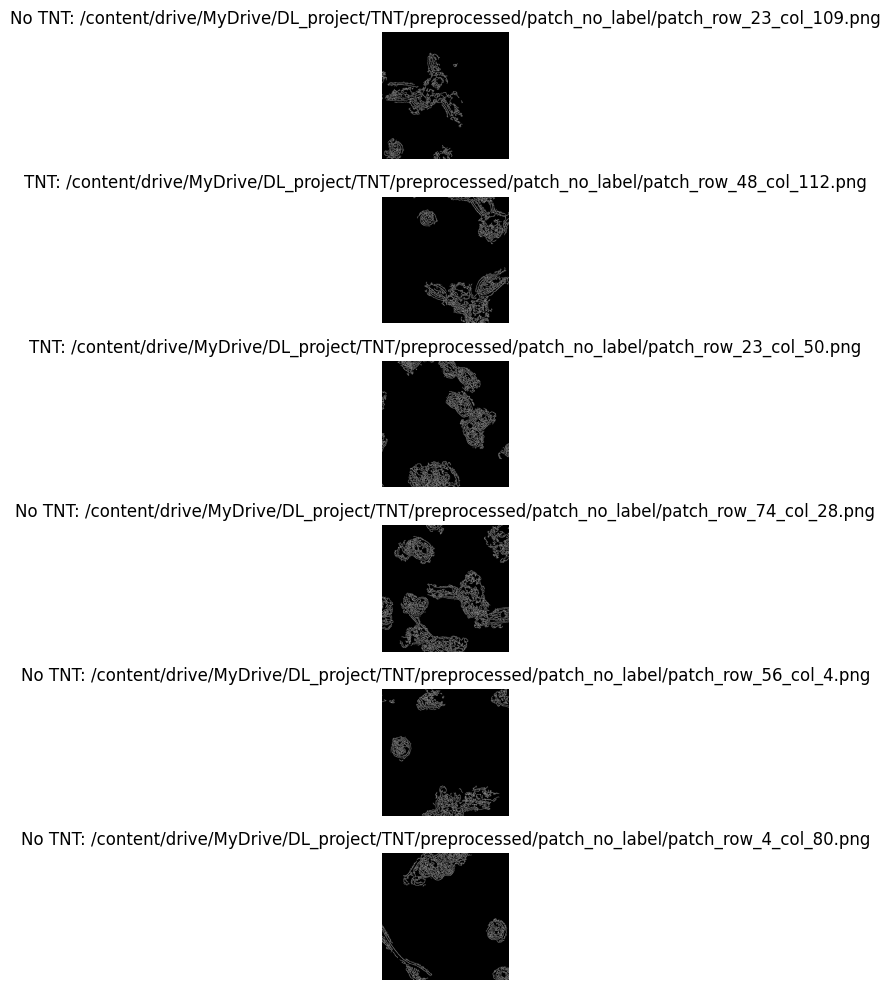

In [106]:
# Visualize the batch of images
fig, axes = plt.subplots(6, 1, figsize=(10, 10))

for i in range(6):
    print(sample_img_paths[i])
    image = Image.open(sample_img_paths[i])
    axes[i].imshow(image, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"{sample_img_labels[i]}: {sample_img_paths[i]}")

plt.tight_layout()
plt.show()

## Build model

In [112]:
# Input shape required by VGG16
IMAGE_WIDTH=512
IMAGE_HEIGHT=512
IMAGE_CHANNELS=3
INP_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
IMAGE_SIZE=(IMAGE_HEIGHT, IMAGE_WIDTH)
BATCH_SIZE = 64

In [113]:
# Load the pre-trained VGGNet model
vgg_model = VGG16(include_top=False,
                  weights='imagenet',
                  input_shape=INP_SHAPE)

# Retrain all the layers
for layer in vgg_model.layers:
    layer.trainable = False

top_model = vgg_model.output
top_model = Flatten(name="flatten")(top_model)

# Adding two dense layers
top_model = Dense(256, activation='relu')(top_model)
top_model = Dense(512, activation='relu')(top_model)
top_model = Dropout(0.2)(top_model)

# We are using binary classification model to identify whether the given patch
# contain TNT or not

output_layer = Dense(1, activation='sigmoid')(top_model)

# Group the convolutional base and new fully-connected layers into a Model object.
model = Model(inputs=vgg_model.input, outputs=output_layer)

In [114]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 512, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 256, 256, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 256, 256, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 256, 256, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 128, 128, 128)     0   

In [115]:
ls

final_preprocessed.png  patch_creation.ipynb  test_df.csv
m05-label.png           patch_label/          train_df.csv
m05.png                 patch_no_label/       val_df.csv


In [116]:
vggmodel_weights_filepath = 'vggmodel_weights.best.hdf5'
if os.path.exists(vggmodel_weights_filepath):
    print('Loading pre-trained weights...')
    model.load_weights(vggmodel_weights_filepath)

In [117]:
#!pip install --upgrade tensorflow

In [118]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       ])

## Define callbacks

In [121]:
callbacks = []

# Saving checkpoints
checkpoint = ModelCheckpoint(vggmodel_weights_filepath,
                             monitor='val_precision',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
callbacks.append(checkpoint)

# Define early_stopping.
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               verbose=1)
callbacks.append(early_stopping)

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_precision',
                              factor=0.1,
                              patience=2)
callbacks.append(reduce_lr)

## Training Generator

In [122]:
#set a seed
seed = 1
np.random.seed(seed)

In [123]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   #shear_range=0.2,
                                   #zoom_range=0.2,
                                   #brightness_range=[0.5, 1],
                                   #width_shift_range=0.2,
                                   #height_shift_range=0.2,
                                   rotation_range=10,
                                   #zoom_range=0.2,
                                   vertical_flip=True,
                                   horizontal_flip=True)


train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                    x_col='image_path',
                                                    y_col='label',
                                                    seed=seed,
                                                    # all images will be resized to configured target size,
                                                    target_size=IMAGE_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='binary',
                                                    )


Found 7795 validated image filenames belonging to 2 classes.


## Validation generator

In [124]:
# preprocess_input from VGG16
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = val_datagen.flow_from_dataframe(dataframe=val_df,
                                                x_col='image_path',
                                                y_col='label',
                                                seed=seed,
                                                # all images will be resized to configured target size,
                                                target_size=IMAGE_SIZE,
                                                batch_size=BATCH_SIZE,
                                                class_mode='binary',
                                                )

Found 974 validated image filenames belonging to 2 classes.


## Test generator

In [125]:
# preprocess_input from VGG16
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,
                                                  x_col='image_path',
                                                  y_col='label',
                                                  seed=seed,
                                                  # all images will be resized to configured target size,
                                                  target_size=IMAGE_SIZE,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='binary',
                                                  shuffle=False
                                                )

Found 975 validated image filenames belonging to 2 classes.


### Check the working of training generator

In [126]:
class_indices = train_generator.class_indices
label_names = list(class_indices.keys())

In [127]:
class_indices

{'No TNT': 0, 'TNT': 1}

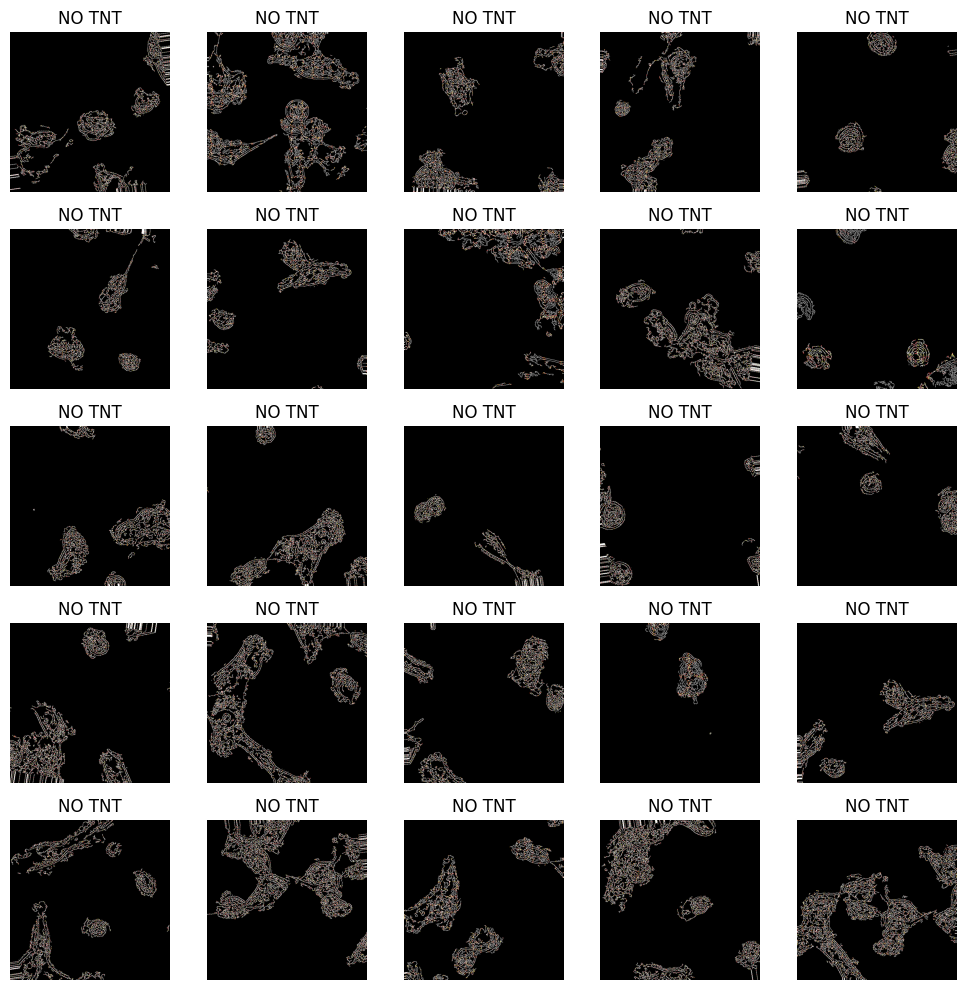

In [128]:
# Retrieve a batch of images from the generator
batch_images, batch_labels = train_generator.next()
batch_label_names = [label_names[np.argmax(label)] for label in batch_labels]

# Visualize the batch of images
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        # Change the channel ordering from BGR to RGB.
        #original_img = batch_images[i*5+j][..., ::-1]
        # Clip the image values to [0, 255]
        #original_img = np.clip(original_img, 0, 255)

        axes[i, j].imshow(batch_images[i*5+j])
        axes[i, j].axis('off')
        axes[i, j].set_title(f"{batch_label_names[i*5 + j].upper()}")

plt.tight_layout()
plt.show()

In [129]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=15,
                    callbacks=callbacks,
                    validation_data=val_generator,
                    validation_steps=len(val_generator))

Epoch 1/15
122/122 [==============================] - ETA: 0s - loss: 2.4954 - precision: 0.3450 - recall: 0.1268
Epoch 1: val_precision improved from -inf to 0.00000, saving model to vggmodel_weights.best.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


122/122 [==============================] - 605s 5s/step - loss: 2.4954 - precision: 0.3450 - recall: 0.1268 - val_loss: 0.6832 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 2/15
122/122 [==============================] - ETA: 0s - loss: 0.6641 - precision: 0.0976 - recall: 0.0032
Epoch 2: val_precision improved from 0.00000 to 0.31250, saving model to vggmodel_weights.best.hdf5
122/122 [==============================] - 608s 5s/step - loss: 0.6641 - precision: 0.0976 - recall: 0.0032 - val_loss: 0.6657 - val_precision: 0.3125 - val_recall: 0.0161 - lr: 0.0010
Epoch 3/15
122/122 [==============================] - ETA: 0s - loss: 0.6333 - precision: 0.3878 - recall: 0.0076
Epoch 3: val_precision improved from 0.31250 to 0.50000, saving model to vggmodel_weights.best.hdf5
122/122 [==============================] - 612s 5s/step - loss: 0.6333 - precision: 0.3878 - recall: 0.0076 - val_loss: 0.6291 - val_precision: 0.5000 - val_recall: 0.0032 - lr: 0.0010
Epoch 4/1

In [143]:
model.save("vggmodel.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


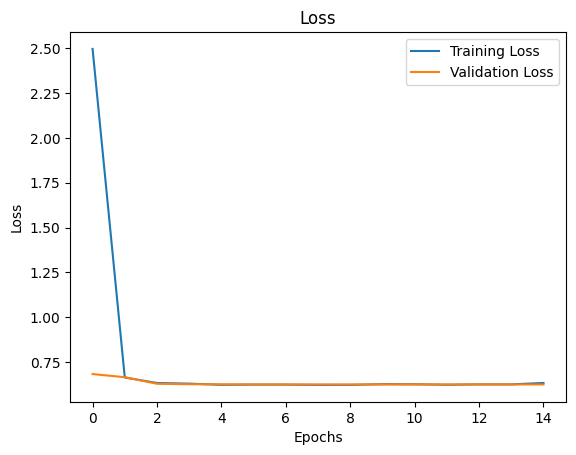

In [130]:
# Plot the loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

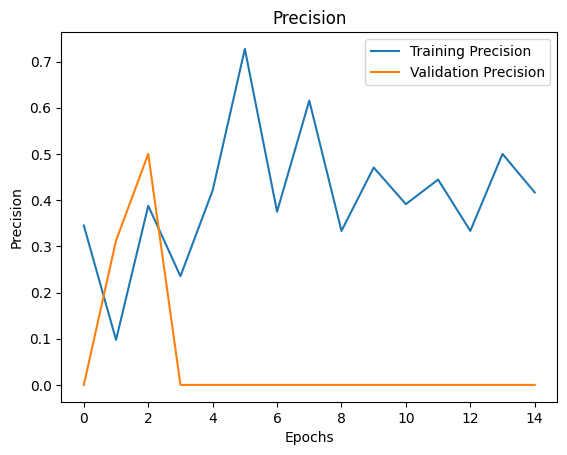

In [131]:
# Plot the precision curve
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

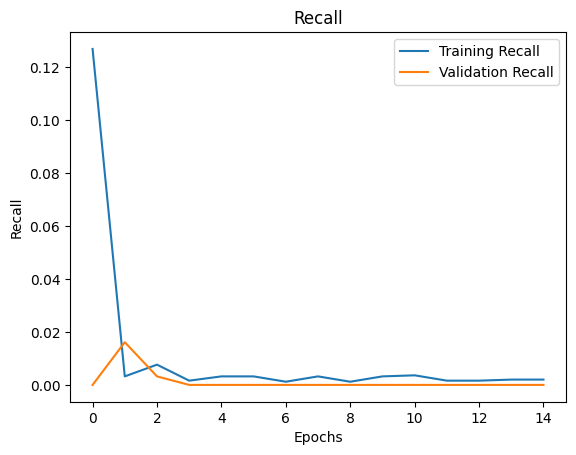

In [132]:
# Plot the precision curve
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

Make predictions on test set

In [133]:
model.load_weights('vggmodel_weights.best.hdf5')

In [134]:
# Make predictions on the test dataset
predictions = model.predict(test_generator)

16/16 [==============================] - 36s 2s/step


In [135]:
test_df.shape

(975, 2)

In [136]:
# Get the predicted class labels
predicted_labels = tf.argmax(predictions, axis=1)
test_df['predicted_label'] = predicted_labels.numpy()

# Get the ground truth labels
true_labels = test_generator.classes

# Calculate precision
precision = tf.keras.metrics.Precision()(true_labels, predicted_labels).numpy()
print("Precision: {:.2f}%".format(precision * 100))

# Calculate recall
recall = tf.keras.metrics.Recall()(true_labels, predicted_labels).numpy()
print("Recall: {:.2f}%".format(recall * 100))


Precision: 0.00%
Recall: 0.00%


In [137]:
test_df

,image_path,label,predicted_label
0,/content/drive/MyDrive/DL_project/TNT/preproce...,No TNT,0
1,/content/drive/MyDrive/DL_project/TNT/preproce...,TNT,0
2,/content/drive/MyDrive/DL_project/TNT/preproce...,No TNT,0
3,/content/drive/MyDrive/DL_project/TNT/preproce...,TNT,0
4,/content/drive/MyDrive/DL_project/TNT/preproce...,TNT,0
...,...,...,...
970,/content/drive/MyDrive/DL_project/TNT/preproce...,No TNT,0
971,/content/drive/MyDrive/DL_project/TNT/preproce...,TNT,0
972,/content/drive/MyDrive/DL_project/TNT/preproce...,No TNT,0
973,/content/drive/MyDrive/DL_project/TNT/preproce...,No TNT,0


In [138]:
test_df['label'].value_counts()

No TNT    664
TNT       311
Name: label, dtype: int64

In [139]:
test_df['predicted_label'].value_counts()

0    975
Name: predicted_label, dtype: int64